# Model comparison between AltumAge w/o regularization, ElasticNet and the Transfomer. 
Export of AA and Transformer models and a csv of comparative results

Includes the shap analysis for the Transformer

# 1. Setup and preprocessing

In [ ]:
import os, numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from my_functions import * 
import random
import matplotlib.pyplot as plt

from glmnet import ElasticNet
from torch.nn.attention import SDPBackend, sdpa_kernel

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, GaussianDropout, ActivityRegularization, Activation


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import shap
import pickle

#setting all seeds
random.seed(1)
tf.random.set_seed(1)
np.random.seed(1)
torch.manual_seed(1)



In [ ]:
#setting tissue_type, split and hyperparams for whole file. All models and output filepaths are adjusted
tissue_type='Skin'
batchsize=8
epochs=50
splitA=0.8
splitB=0.2

In [79]:
#important filepaths
DATA_DIR = f"/sybig/home/fim/Dokumente/Sysbio/AltumAgeNew/data_by_tissue/{tissue_type}/"
TRAIN_PATH = os.path.join(DATA_DIR, f"train_{tissue_type}.pkl")
TEST_PATH  = os.path.join(DATA_DIR, f"test_{tissue_type}.pkl")
CPG_PATH   = "/sybig/home/fim/Dokumente/Sysbio/Transformer/cpgs.npy"

#data loading
train_val_data = pd.read_pickle(TRAIN_PATH)
test_data      = pd.read_pickle(TEST_PATH)
cpgs           = np.load(CPG_PATH, allow_pickle=True)

#split
all_data=pd.concat([train_val_data,test_data])
all_data.sample(frac=1,random_state=1)
print(all_data.head)
train_val_data,test_data=train_test_split(all_data, test_size=splitB, random_state=1)

#cleaning up age data
train_val_data['age'] = pd.to_numeric(train_val_data['age'], errors='coerce')
train_val_data = train_val_data.dropna(subset=['age'])
test_data['age'] = pd.to_numeric(test_data['age'], errors='coerce')
test_data = test_data.dropna(subset=['age'])

#split 2, adjusted by tissue types for the transformer
try:
    train_df, val_df = train_test_split(
        train_val_data,
        test_size=splitB,
        stratify=train_val_data['tissue_type'],
        random_state=1
    )
    print("Stratified split successful.")
except ValueError:
    # If stratification fails due to small class sizes
    train_df, val_df = train_test_split(
        train_val_data,
        test_size=splitB,
        random_state=1
    )
    print("Random split used (too few samples per tissue).")


#keeping only features
meta_cols = ['age', 'tissue_type', 'tissue_idx', 'dataset', 'gender']
feature_cols = cpgs
num_features = len(feature_cols)
print(f"Using {num_features} CpG features.")

#scaling by training data
scaler = RobustScaler()
train_scaled = pd.DataFrame(
    scaler.fit_transform(train_df[feature_cols]),
    index=train_df.index,
    columns=feature_cols
)
val_scaled = pd.DataFrame(
    scaler.transform(val_df[feature_cols]),
    index=val_df.index,
    columns=feature_cols
)
test_scaled = pd.DataFrame(
    scaler.transform(test_data[feature_cols]),
    index=test_data.index,
    columns=feature_cols
)

#get tissue mapping for embedding (transformer)
all_tissues = pd.concat([
    train_df['tissue_type'],
    val_df['tissue_type'],
    test_data['tissue_type']
]).unique()
tissue_mapping = {t: i for i, t in enumerate(all_tissues)}
num_tissues = len(tissue_mapping)
print("Total tissue types:", num_tissues)

def map_tissue(df):
    return df['tissue_type'].map(tissue_mapping)

train_df['tissue_idx'] = map_tissue(train_df)
val_df['tissue_idx']   = map_tissue(val_df)
test_data['tissue_idx'] = map_tissue(test_data)


#converting to tensors for transformer
def df_to_tensor(df_scaled, tissue_idx, ages):
    X = torch.tensor(df_scaled.values.astype(np.float32), dtype=torch.float32)
    t = torch.tensor(tissue_idx.values, dtype=torch.long)
    y = torch.tensor(ages.values, dtype=torch.float32)
    return X, t, y

X_train, tissue_train, y_train = df_to_tensor(train_scaled, train_df['tissue_idx'], train_df['age'])
X_val, tissue_val, y_val       = df_to_tensor(val_scaled,   val_df['tissue_idx'],   val_df['age'])
X_test, tissue_test, y_test    = df_to_tensor(test_scaled,  test_data['tissue_idx'], test_data['age'])

#converting to np arrays for ElasticNet
X_train_np, y_train_np = train_scaled.values, train_df['age'].values
X_val_np,   y_val_np   = val_scaled.values,   val_df['age'].values
X_test_np,  y_test_np  = test_scaled.values,  test_data['age'].values

print("Final shapes:")
print(" Train:", X_train.shape, y_train.shape)
print(" Val:  ", X_val.shape, y_val.shape)
print(" Test: ", X_test.shape, y_test.shape)


<bound method NDFrame.head of       dataset tissue_type    age gender  cg00000292  cg00002426  cg00003994  \
0    GSE90124        skin  53.92      F    0.733081    0.480596    0.054303   
1    GSE90124        skin  58.35      F    0.668161    0.536596    0.029813   
2    GSE90124        skin  49.36      F    0.708498    0.424246    0.172421   
3    GSE90124        skin  78.24      F    0.736776    0.540731    0.048218   
4    GSE90124        skin  62.22      F    0.671724    0.512526    0.062416   
..        ...         ...    ...    ...         ...         ...         ...   
152  GSE22595      dermis   6.00    NaN    0.396513    0.261713    0.036592   
153  GSE22595      dermis  23.00    NaN    0.348558    0.404460    0.044582   
154  GSE22595      dermis  17.00    NaN    0.532723    0.527898    0.048692   
155  GSE22595      dermis  73.00    NaN    0.391073    0.281650    0.050583   
156  GSE22595      dermis   6.00    NaN    0.456030    0.252995    0.041890   

     cg00005847  cg00

#   2. ELASTICNET



In [ ]:
#mostly like original, adjusted params and w/o unknown array

elastic_net_model = ElasticNet(
    alpha=0.5,             
    n_lambda=100,         
    min_lambda_ratio=0.0001,
    random_state=1
)

elastic_net_model.fit(X_train_np, transform_age(y_train_np))

# val
pred_ages_val = elastic_net_model.predict(X_val_np)
pred_ages_val = anti_transform_age(pred_ages_val)
pred_ages_val = pd.Series(pred_ages_val, index=val_df.index, name="pred_age")

elastic_net_val_results = pd.concat([val_df, pred_ages_val], axis=1)

# testing
pred_ages_test = elastic_net_model.predict(X_test_np)
pred_ages_test = anti_transform_age(pred_ages_test)
pred_ages_test = pd.Series(pred_ages_test, index=test_data.index, name="pred_age")

elastic_net_test_results = pd.concat([test_data, pred_ages_test], axis=1)



'\'\'\n\nelastic_net_model = ElasticNet(\n    alpha=0.5,              # L1/L2 mixing parameter\n    n_lambda=100,           # number of lambdas in path\n    min_lambda_ratio=0.0001,\n    random_state=1\n)\n\nelastic_net_model.fit(X_train_np, transform_age(y_train_np))\n\n# --- Validation ---\npred_ages_val = elastic_net_model.predict(X_val_np)\npred_ages_val = anti_transform_age(pred_ages_val)\npred_ages_val = pd.Series(pred_ages_val, index=val_df.index, name="pred_age")\n\nelastic_net_val_results = pd.concat([val_df, pred_ages_val], axis=1)\n\n# --- Testing ---\npred_ages_test = elastic_net_model.predict(X_test_np)\npred_ages_test = anti_transform_age(pred_ages_test)\npred_ages_test = pd.Series(pred_ages_test, index=test_data.index, name="pred_age")\n\nelastic_net_test_results = pd.concat([test_data, pred_ages_test], axis=1)\n'

#   3. TISSUE-GATED TRANSFORMER

In [ ]:


#model def
class TissueGatedTransformer(nn.Module):
    """
    A Transformer-based model that uses tissue-specific gating 
    to predict age from methylation data.
    """
    def __init__(self, num_features=20318, num_tissues=num_tissues, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.tissue_embedding = nn.Embedding(num_tissues, 16)
        self.attention_gate = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, num_features),
            nn.Sigmoid()
        )
        self.feature_projection = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=4*d_model,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.positional_encoding = nn.Parameter(torch.randn(1, 1, d_model))
        self.regression_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 32),
            nn.SELU(),
            nn.Linear(32, 1)
        )

    def forward(self, methylation, tissue_id):
        tissue_emb = self.tissue_embedding(tissue_id)
        attn_weights = self.attention_gate(tissue_emb)
        gated_features = methylation * attn_weights
        projected = self.feature_projection(gated_features)
        transformer_input = projected.unsqueeze(1) + self.positional_encoding
        transformer_output = self.transformer(transformer_input)
        pooled = transformer_output.squeeze(1)
        age_pred = self.regression_head(pooled)
        return age_pred.squeeze(-1)

#helper functions
def train(model, train_loader, val_loader, num_epochs=epochs, lr=0.001, model_path='best_model.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for methylation, tissue_id, ages in train_loader:
            methylation, tissue_id, ages = methylation.to(device), tissue_id.to(device), ages.to(device)
            optimizer.zero_grad()
            with sdpa_kernel(SDPBackend.MATH):  # from your file
                outputs = model(methylation, tissue_id)
            loss = criterion(outputs, ages)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * methylation.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for methylation, tissue_id, ages in val_loader:
                methylation, tissue_id, ages = methylation.to(device), tissue_id.to(device), ages.to(device)
                outputs = model(methylation, tissue_id)
                val_loss += criterion(outputs, ages).item() * methylation.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Epoch {epoch+1} | Val Loss {val_loss:.4f} (best saved)")
    model.load_state_dict(torch.load(model_path))
    return model, train_losses, val_losses

def save_model(model, path='tissue_transformer.pth'):
    torch.save(model, path)
    print(f'Model saved to {path}')

def load_model(model_class, path, **model_args):
    model = model_class(**model_args)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    return model

def predict(model, test_loader, output_csv='predictions.csv'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).eval()
    predictions = []
    with torch.no_grad():
        for methylation, tissue_id, _ in test_loader:
            methylation, tissue_id = methylation.to(device), tissue_id.to(device)
            batch_preds = model(methylation, tissue_id)
            predictions.append(batch_preds.cpu())
    predictions = torch.cat(predictions).numpy()
    pd.DataFrame({
        'sample_id': range(len(predictions)),
        'predicted_age': predictions
    }).to_csv(output_csv, index=False)
    print(f'Saved predictions to {output_csv}')
    return predictions

#added for convenience
def evaluate_regression(true_ages, predicted_ages, output_csv):
    mae = np.mean(np.abs(true_ages - predicted_ages))
    mse = np.mean((true_ages - predicted_ages) ** 2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_ages - predicted_ages) ** 2)
    ss_tot = np.sum((true_ages - np.mean(true_ages)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else float('nan')
    corr_coef, p_val = pearsonr(true_ages, predicted_ages)
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'pearson': corr_coef,
        'p-value': p_val
    }
    pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value']).to_csv(output_csv, index=False)
    print(f"Metrics saved to {output_csv}")
    return metrics


In [82]:
#important paths
model_dir = "/sybig/home/fim/Dokumente/Sysbio/All_models/Transformer_model/" 
best_model_path = os.path.join(model_dir, f'best_transformer_{splitA}_{tissue_type}.pth')
final_model_path = os.path.join(model_dir, f'final_transformer_{splitA}_{tissue_type}.pth')
predictions_path = f'/sybig/home/fim/Dokumente/Sysbio/All_models/test_predictions{splitA}_{tissue_type}.csv'
output_csv=f"/sybig/home/fim/Dokumente/Sysbio/All_models/stats_{splitA}_{tissue_type}.csv"

#dataloader prep
train_dataset = TensorDataset(X_train, tissue_train, y_train)
val_dataset = TensorDataset(X_val, tissue_val, y_val)
test_dataset = TensorDataset(X_test, tissue_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batchsize)
val_loader = DataLoader(val_dataset, batch_size=batchsize)
test_loader = DataLoader(test_dataset, batch_size=batchsize) 

# Initialize the model
model = TissueGatedTransformer(
    num_features=num_features,
    num_tissues=len(tissue_mapping),  # Assuming 'tissue_mapping' created earlier
    d_model=64,
    nhead=4,
    num_layers=3
)

# Train
trained_model, train_losses, val_losses = train(
    model, train_loader, val_loader,
    num_epochs=epochs,
    lr=0.001,
    model_path=best_model_path
)

# Saving final model
save_model(trained_model, final_model_path)

# Reloading checkpoint
loaded_model = load_model(
    TissueGatedTransformer, best_model_path,
    num_features=num_features,
    num_tissues=len(tissue_mapping),
    d_model=64,
    nhead=4,
    num_layers=3
)

# Predicting
preds = predict(loaded_model, test_loader, output_csv=predictions_path)

# Evaluating
metrics = evaluate_regression(
    true_ages=y_test.numpy(),
    predicted_ages=preds,
    output_csv=output_csv
)

print(metrics)


Training on device: cpu
Epoch 1 | Val Loss 2428.9951 (best saved)
Epoch 2 | Val Loss 1431.5623 (best saved)
Epoch 3 | Val Loss 532.3505 (best saved)
Epoch 4 | Val Loss 262.9223 (best saved)
Epoch 6 | Val Loss 229.8999 (best saved)
Epoch 7 | Val Loss 209.2399 (best saved)
Epoch 8 | Val Loss 164.1260 (best saved)
Epoch 9 | Val Loss 162.4905 (best saved)
Epoch 10 | Val Loss 158.1522 (best saved)
Epoch 11 | Val Loss 154.9649 (best saved)
Epoch 23 | Val Loss 150.1418 (best saved)
Epoch 31 | Val Loss 126.1948 (best saved)
Epoch 33 | Val Loss 123.2642 (best saved)
Epoch 37 | Val Loss 116.9550 (best saved)
Epoch 42 | Val Loss 109.5359 (best saved)
Epoch 48 | Val Loss 108.5893 (best saved)
Model saved to /sybig/home/fim/Dokumente/Sysbio/All_models/Transformer_model/final_transformer_0.8_Skin.pth
Saved predictions to /sybig/home/fim/Dokumente/Sysbio/All_models/test_predictions0.8_Skin.csv
Metrics saved to /sybig/home/fim/Dokumente/Sysbio/All_models/stats_0.8_Skin.csv
{'MAE': 6.5208507, 'MSE': 94

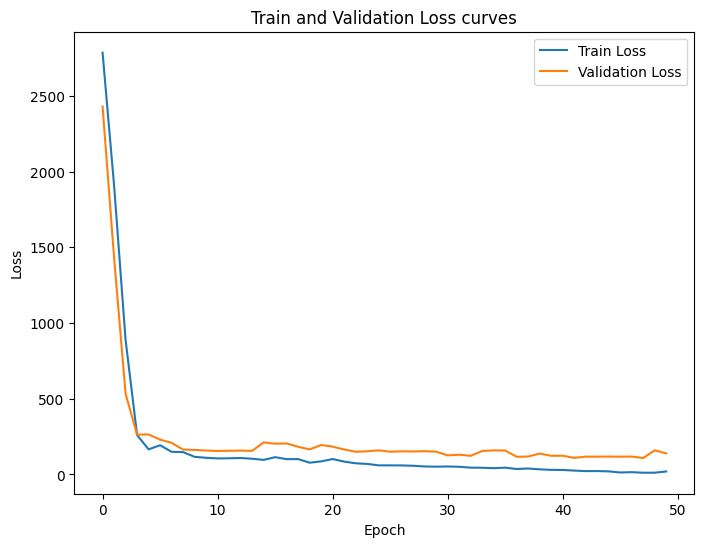

In [83]:

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss curves')
plt.legend()
plt.show()

In [ ]:
#shap analysis, because all data + dataloaders are already available
'''''
loaded_model.eval()

#wrapper to avoid tuple error
class ShapModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, methylation, tissue_id):

        tissue_id_long = tissue_id.long().detach()

        dummy_tensor = torch.sum(methylation * tissue_id.unsqueeze(1)) * 1e-9

        output = self.model(methylation, tissue_id_long)
        
        # Add the dummy tensor to the output to ensure a gradient path exists
        final_output = output + dummy_tensor

        return final_output.unsqueeze(1)
    
wrapped_model = ShapModelWrapper(loaded_model)

background_data, background_tissue, _ = next(iter(DataLoader(train_dataset, batch_size=100)))

test_data, test_tissue, _ = next(iter(DataLoader(test_dataset, batch_size=100)))
background_tissue = background_tissue.float()
test_tissue= test_tissue.float()

#SHAP USING GRADIENT EXPLAINER!!
explainer = shap.GradientExplainer(wrapped_model, [background_data, background_tissue])
shap_values = explainer.shap_values([test_data, test_tissue])
methylation_shap_values = shap_values[0]

save_dir = "All_models/SHAP"
filepath = os.path.join(save_dir, f"shap_Transformer_80:20_{tissue_type}.pkl")
with open(filepath, 'wb') as f:
    pickle.dump(methylation_shap_values, f)

print(f"Saved SHAP values to {filepath}")
'''''


Saved SHAP values to All_models/SHAP/shap_Transformer_80:20_Skin.pkl


#   4. ALTUMAGE

In [ ]:
#adjusted coeffs 
coeff = 0.05 * np.sqrt(2.0 * np.log(train_scaled.shape[1]) / train_scaled.shape[1])
noise = 0.1
input_shape = train_scaled.shape[1]
initializer = tf.keras.initializers.LecunNormal(seed=1)

#model architecture
nn_model = Sequential([
    Input(shape=(input_shape,), name='feature'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, coeff*10),
    Dense(32, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    Dense(1)
])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=30,
    min_lr=1e-5
)

checkpoint_filepath = f"/sybig/home/fim/Dokumente/Sysbio/All_models/AltumAge_models/All_models_best_altumage_8.0{tissue_type}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

#model definition
model = nn_model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

#training
history = model.fit(
    np.array(train_scaled),
    np.array(train_df['age']),
    validation_data=(np.array(val_scaled), np.array(val_df['age'])),
    batch_size=batchsize,
    epochs=epochs,
    verbose=1,
    callbacks=[model_checkpoint_callback, reduce_lr]
)

#restoring best weights
model.load_weights(checkpoint_filepath)

#testing
altumage_preds = model.predict(np.array(test_scaled)).flatten()
pd.DataFrame({
    "sample_id": range(len(altumage_preds)),
    "predicted_age": altumage_preds
}).to_csv(f"predictions_altumage_{splitA}_{tissue_type}.csv", index=False)



Epoch 1/100
33/33 [==============================] - 9s 87ms/step - loss: 2444.6790 - mae: 40.0957 - val_loss: 2100.7917 - val_mae: 38.3700 - lr: 0.0020
Epoch 2/100
33/33 [==============================] - 2s 74ms/step - loss: 2151.6672 - mae: 39.2239 - val_loss: 2129.2178 - val_mae: 40.9094 - lr: 0.0020
Epoch 3/100
33/33 [==============================] - 2s 76ms/step - loss: 1912.7222 - mae: 37.9411 - val_loss: 1945.2437 - val_mae: 39.7312 - lr: 0.0020
Epoch 4/100
33/33 [==============================] - 2s 67ms/step - loss: 1678.7087 - mae: 36.2608 - val_loss: 2085.3267 - val_mae: 42.0078 - lr: 0.0020
Epoch 5/100
16/33 [=============>................] - ETA: 1s - loss: 1473.3400 - mae: 34.2969

KeyboardInterrupt: 

/sybig/home/fim/Dokumente/Sysbio/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


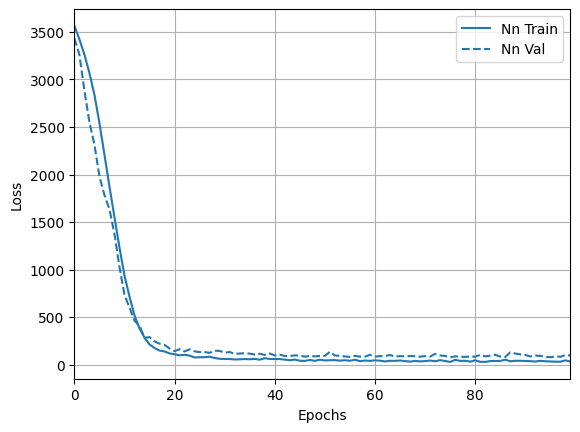

In [ ]:
#saving final model
model.save(f'/sybig/home/fim/Dokumente/Sysbio/All_models/AltumAge_models/AltumAge_npj_80:20_{tissue_type}.h5')

#visualization
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot({'nn':history})


#   5. COMPARATIVE RESULTS

In [ ]:
#calculating MAE,MSE,RMSE,R2 and pearson corr
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    corr, _ = pearsonr(y_true, y_pred)
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Pearson": corr
    }

#all metrics
elasticnet_metrics = evaluate_metrics(y_test, pred_ages_test.values)
altumage_metrics = evaluate_metrics(y_test, altumage_preds.flatten())
transformer_metrics = evaluate_metrics(y_test.numpy(), preds)

all_results = pd.DataFrame({
    "ElasticNet (glmnet)": elasticnet_metrics,
    "AltumAge (Keras)": altumage_metrics,
    "Transformer (PyTorch)": transformer_metrics
}).T

#saving metrics
comparative_csv = f"All_models/comparative_results__{splitA}_{tissue_type}.csv"
all_results.to_csv(comparative_csv)
print(f"Comparative results saved to {comparative_csv}")
display(all_results)


Comparative results saved to All_models/comparative_results__0.8_Skin.csv


,MAE,MSE,RMSE,R2,Pearson
ElasticNet (glmnet),4.769215,36.801834,6.066452,0.814889,0.915327
AltumAge (Keras),4.758545,44.161095,6.645381,0.777873,0.889030
Transformer (PyTorch),6.495337,85.800636,9.262863,0.568428,0.791512
